<a href="https://colab.research.google.com/github/RamSaw/deep-unsupervised-learning/blob/hw_01/HW01_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 3 PixelCNN

In [1]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.autograd import Variable
from torch import cuda
from mpl_toolkits.mplot3d import Axes3D
import pickle
import datetime
from pathlib import Path
import torchvision
SEED = 24839
torch.manual_seed(SEED)
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
dataset = None
with open('mnist-hw1.pkl', 'rb') as data_file:
  dataset = pickle.load(data_file)

X_train = dataset['train']
X_train, X_val = train_test_split(X_train, test_size=0.1, random_state=42)
X_test = dataset['test']
X_train, X_val, X_test = torch.tensor(X_train).transpose(1, 3).float(), torch.tensor(X_val).transpose(1, 3).float(), torch.tensor(X_test).transpose(1, 3).float()
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(X_train[0][0][0][0])

torch.Size([54000, 3, 28, 28])
torch.Size([6000, 3, 28, 28])
torch.Size([10000, 3, 28, 28])
tensor(3.)


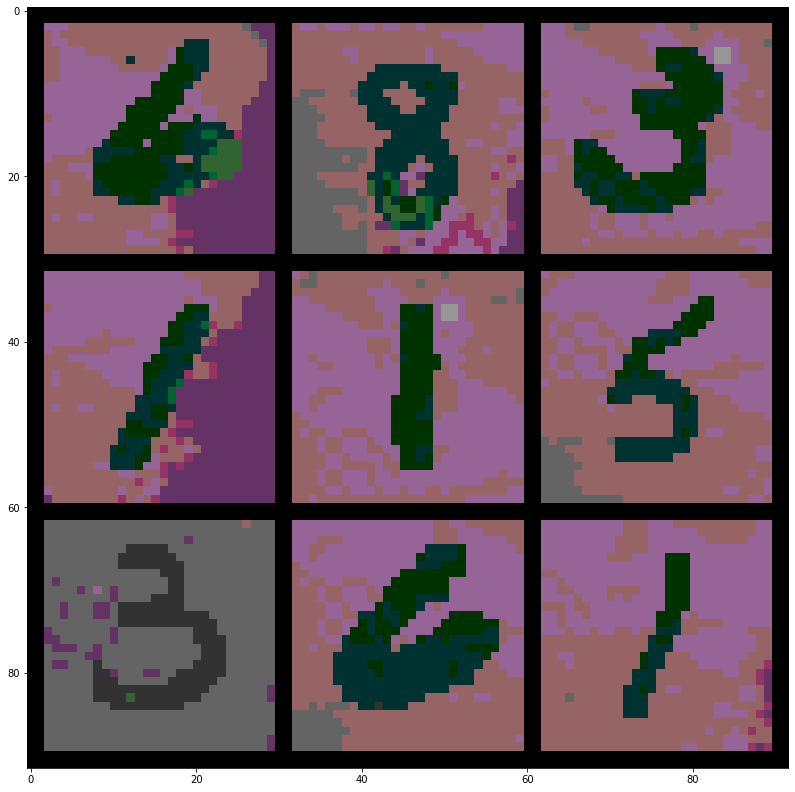

In [3]:
def imshow(grid):
    npimg = grid.cpu().numpy()
    plt.figure(figsize=[14, 14])
    plt.imshow(np.transpose(npimg, (2, 1, 0)) * 50)
    plt.show()

grid = torchvision.utils.make_grid(X_train[100:109].long(), nrow=3)
imshow(grid)

In [4]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        self.register_buffer('mask', self.weight.data.clone())
        _, _, kH, kW = self.weight.size()
        self.mask.fill_(1)
        self.mask[:, :, kH // 2, kW // 2 + (mask_type == 'B'):] = 0
        self.mask[:, :, kH // 2 + 1:] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)
  
def test_MaskedConv2d():
  model_A = MaskedConv2d('A', 2, 3, (5, 4))
  for param in model_A.parameters():
      if param.requires_grad:
        print(param.data.shape)
  model_B = MaskedConv2d('B', 2, 3, (5, 4))
  for param in model_B.parameters():
      if param.requires_grad:
        print(param.data.shape)
test_MaskedConv2d()

torch.Size([3, 2, 5, 4])
torch.Size([3])
torch.Size([3, 2, 5, 4])
torch.Size([3])


In [5]:
class ResidualBlock(nn.Module):
  def __init__(self, h):
    super(ResidualBlock, self).__init__()
    self.block = nn.Sequential(
        nn.ReLU(),
        MaskedConv2d('B', 2 * h, h, kernel_size=1),
        nn.BatchNorm2d(h),
        nn.ReLU(),
        MaskedConv2d('B', h, h, kernel_size=3, padding=1),
        nn.BatchNorm2d(h),
        nn.ReLU(),
        MaskedConv2d('B', h, 2 * h, kernel_size=1),
        nn.BatchNorm2d(2 * h),
    )
  
  def forward(self, x):
    return self.block(x)
    
def test_ResidualBlock():
  model = ResidualBlock(2)
  for param in model.parameters():
      if param.requires_grad:
        print(param.data.shape)
test_ResidualBlock()

torch.Size([2, 4, 1, 1])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2, 2, 3, 3])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([4, 2, 1, 1])
torch.Size([4])
torch.Size([4])
torch.Size([4])


In [6]:
h = 128
layers = [
  MaskedConv2d('A', 3,  2 * h, 7, stride=1, padding=3, bias=False), 
  nn.BatchNorm2d(2 * h),
  nn.ReLU()
]
layers += [ResidualBlock(h) for i in range(12)]
layers += [
   nn.ReLU(),
   MaskedConv2d('B', 2 * h, 2 * h, 1),
   nn.BatchNorm2d(2 * h),
   nn.ReLU(),
   nn.Conv2d(2 * h, 3 * 4, 1)
]

def test_model():
  model = nn.Sequential(*layers)
  print(model)
  trainloader = DataLoader(X_train, batch_size=128, shuffle=True)
  for batch in trainloader:
    print(batch.size())
    model.train(False)
    out = model(batch)
    print(out.shape)
    break

test_model()

Sequential(
  (0): MaskedConv2d(3, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): ResidualBlock(
    (block): Sequential(
      (0): ReLU()
      (1): MaskedConv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
      (4): MaskedConv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaskedConv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
      (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (4): ResidualBlock(
    (block): Sequential(
      (0): ReLU()
      (1): MaskedConv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1

In [0]:
def loss_function(out, batch):
  out = out.reshape(out.shape[0], 3, 4, 28, 28).permute(0, 1, 3, 4, 2)
  probs = F.softmax(out, dim=-1)
  target = F.one_hot(batch.to(torch.int64), -1)
  probs = (probs * target).sum(dim=-1)
  return -torch.sum(torch.log(probs)) / len(probs)

In [0]:
batch_size = 128
trainloader = DataLoader(X_train, batch_size=batch_size, shuffle=True)
valloader = DataLoader(X_val, batch_size=batch_size, shuffle=False)
testloader = DataLoader(X_test, batch_size=batch_size, shuffle=False)

In [0]:
model = None
dimensions = 28 * 28 * 3

In [0]:
num_epochs = 15
lr = 1e-3
#torch.autograd.set_detect_anomaly(True)
model = nn.Sequential(*layers)
if Path('./model.pkl').exists():
  model.load_state_dict(torch.load('./model.pkl'))
  print('Model loaded!')
model.to(device)
#model.cuda()
optimizer = optim.Adam(model.parameters(), lr=lr)
losses_train = []
losses_val = []
num_batches = len(trainloader)
for epoch in range(num_epochs):
  #cuda.synchronize()
  time_tr = time.time()
  model.train(True)
  losses_train_per_epoch = []
  for i, batch in enumerate(trainloader):
      #batch = Variable(batch.cuda(async=True))
      batch = batch.to(device)
      out = model(batch)
      loss = loss_function(out, batch)
      losses_train_per_epoch.append(float(loss) / dimensions / np.log(2))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if i % 50 == 0:
        print(f'Loss on batch {i} / {num_batches}: {losses_train_per_epoch[-1]}')
  #cuda.synchronize()
  losses_train.append(np.mean(losses_train_per_epoch))
  time_tr = time.time() - time_tr
  print(f'Training time: {time_tr}')
  #torch.cuda.empty_cache()

  # compute error on test set
  #cuda.synchronize()
  time_te = time.time()
  losses_val_per_epoch = []
  model.train(False)
  with torch.no_grad():
    for batch in valloader:
        #batch = Variable(batch.cuda(async=True))
        batch = batch.to(device)
        out = model(batch)
        loss = loss_function(out, batch)
        losses_val_per_epoch.append(float(loss) / dimensions / np.log(2))
  #cuda.synchronize()
  losses_val.append(np.mean(losses_val_per_epoch))
  time_te = time.time() - time_te
  print(f'Validation loss: {losses_val[-1]}')
  print(f'Validation time: {time_te}')
  print(f'Epoch {epoch} / {num_epochs}')
  #torch.cuda.empty_cache()
  if epoch % 5 == 0:
    torch.save(model.state_dict(), "./model.pkl")
    print("Model saved!")
torch.save(model.state_dict(), "./model.pkl")

Model loaded!
Loss on batch 0 / 422: 0.12191866498964588
Loss on batch 50 / 422: 0.11609465386042776
Loss on batch 100 / 422: 0.12211568457063428
Loss on batch 150 / 422: 0.12289687422895339
Loss on batch 200 / 422: 0.11783114045713942
Loss on batch 250 / 422: 0.1209647626316603
Loss on batch 300 / 422: 0.11959354378638112
Loss on batch 350 / 422: 0.12482828385624294
Loss on batch 400 / 422: 0.12244371047347993
Training time: 115.36540532112122
Validation loss: 0.12523229935616773
Validation time: 4.238876104354858
Epoch 0 / 15
Model saved!
Loss on batch 0 / 422: 0.1274985683900393
Loss on batch 50 / 422: 0.11971718410300139
Loss on batch 100 / 422: 0.12117524131751622
Loss on batch 150 / 422: 0.11888540580642849
Loss on batch 200 / 422: 0.12254699365999808
Loss on batch 250 / 422: 0.1264254528062557
Loss on batch 300 / 422: 0.11943587196399011
Loss on batch 350 / 422: 0.12508959452995388
Loss on batch 400 / 422: 0.12425250934015437
Training time: 115.30396842956543
Validation loss: 0.

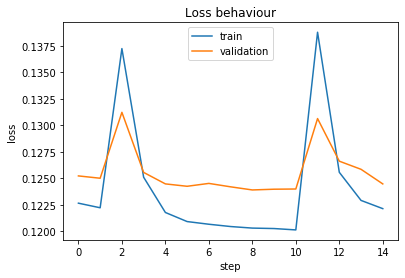

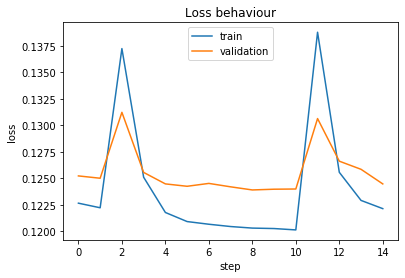

In [0]:
fig, ax = plt.subplots()
ax.set(xlabel='step', ylabel='loss',
       title='Loss behaviour')
ax.plot(np.arange(len(losses_train)), losses_train, label="train")
ax.plot(np.arange(len(losses_train)), losses_val, label="validation")
ax.legend()
plt.show()

In [10]:
if model is None or Path('./model_50.pkl').exists():
  model = nn.Sequential(*layers)
  model.load_state_dict(torch.load('./model_50.pkl'))
  print('Loaded model trained on 50 epochs!')

model.to(device)
model.train(False)
test_losses = []
with torch.no_grad():
  for batch in testloader:
      #batch = Variable(batch.cuda(async=True))
      batch = batch.to(device)
      out = model(batch)
      loss = loss_function(out, batch)
      test_losses.append(float(loss) / dimensions / np.log(2))
print(f'Loss on test data: {np.mean(test_losses)}')

Loaded model trained on 50 epochs!
Loss on test data: 0.12339636978179852


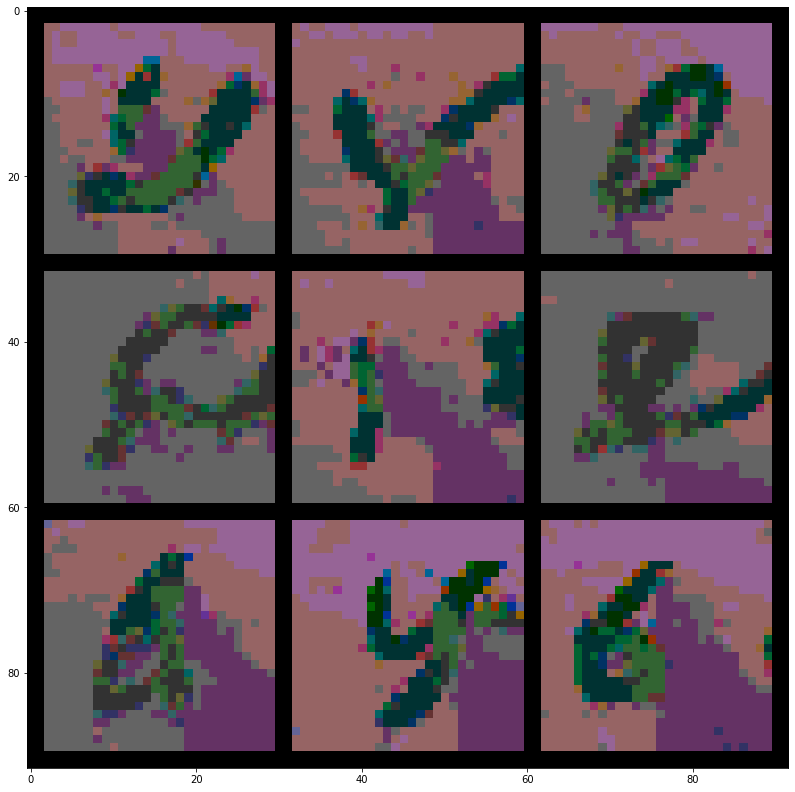

In [11]:
def sample_images(model, N=9):
  model.to(device)
  samples = torch.zeros((N, 3, 28, 28)).to(device)
  with torch.no_grad():
    for y in range(28):
      for x in range(28):
        for c in range(3):
          probs = model(samples)
          probs = probs.reshape(probs.shape[0], 3, 4, 28, 28).permute(0, 1, 3, 4, 2)
          probs = F.softmax(probs, dim=-1).detach().cpu().numpy()
          for i in range(N):
            samples[i, c, y, x] = np.random.choice(4, p=probs[i, c, y, x])
  return samples

sampled_images = sample_images(model, 9)
grid = torchvision.utils.make_grid(sampled_images.long(), nrow=3)
imshow(grid)

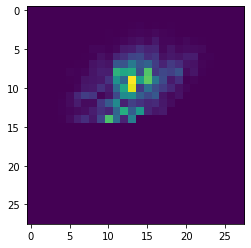

In [12]:
def receptive_field():
  example = X_train[0].clone().detach().unsqueeze(0).to(device).requires_grad_(True)
  model = nn.Sequential(*layers)
  model.to(device)
  probs = model(example)[:, 0, 14, 14]
  
  loss = -torch.log(probs)
  loss.backward()
  
  img, img_ind = example.grad[0].abs().max(dim=0)
  
  plt.imshow(img.detach().cpu().numpy())
  plt.show()

receptive_field()